In [1]:
import json
import random
import math
import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

FILE_NAME = 'model.json'


class Sample:
    def __init__(self, input, expected):
        self.input = input
        self.expected = expected

    def show(self):
        plt.imshow(self.input.reshape(28, 28), cmap='gray')
        plt.show()


def combine_samples(samples):
    inpt = np.array([x.input for x in samples]).transpose()
    expect = np.array([x.expected for x in samples]).transpose()
    return Sample(inpt, expect)


def get_samples(train):
    samples = []
    x_train, t_train, x_test, t_test = mnist_load()
    if train:
        data = zip(x_train, t_train)
    else:
        data = zip(x_test, t_test)
    for x, y in data:
        one_hot = np.array([int(i == y) for i in range(10)])
        samples.append(Sample(np.vectorize(lambda x : x / 255)(x), one_hot))
    return samples


def mnist_load():
    with open("../datasets/mnist/mnist.pkl", "rb") as f:
        mnist = pickle.load(f)
    return (
        mnist["training_images"],
        mnist["training_labels"],
        mnist["test_images"],
        mnist["test_labels"],
    )


def show_random_wrong_sample(score):
    wrong = []
    for pred in score.predictions:
        if pred.sample.expected.argmax() != pred.prediction.argmax():
            wrong.append(pred)
    w = wrong[random.randint(0, len(wrong))]
    print('Expected: ', w.sample.expected.argmax())
    print('Got: ', w.prediction.argmax())
    w.sample.show()


class Prediction:
    def __init__(self, sample, prediction):
        self.sample = sample
        self.prediction = prediction


class ScoreResult:
    def __init__(self, accuracy, loss, predictions):
        self.accuracy = accuracy
        self.loss = loss
        self.predictions = predictions

    def __str__(self):
        return f"accuracy: {self.accuracy * 100}%, loss: {self.loss}"


class RunResult:
    def __init__(self, activations, weighted_inputs):
        self.activations = activations
        self.weighted_inputs = weighted_inputs

In [2]:
train_data = get_samples(True)
test_data = get_samples(False)

In [3]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def init_params(self, model):
        self.model = model

    def step(self, grad_w, grad_b, batch):
        for i in range(1, len(self.model.layers)):
            self.model.weights[i] -= self.lr * grad_w[i]
            self.model.biases[i] -= self.lr * grad_b[i]

In [4]:
class Network:
    def __init__(self, layers, optimizer, batch_size, l1=0, l2=0, dropout_rate=0):
        self.current_epoch = 0
        self.layers = layers
        self.weights = [None]
        self.biases = [None]
        self.batch_size = batch_size
        for i in range(1, len(layers)):
            self.weights.append(np.random.uniform(-1, -1, (layers[i], layers[i - 1])) * np.sqrt(1/layers[i - 1]))
            self.biases.append(np.random.uniform(-1, 1, layers[i]))
        self.optimizer = optimizer
        self.l1 = l1
        self.l2 = l2
        self.dropout_rate = dropout_rate
        self.dropout_masks = [None]
        optimizer.init_params(self)

    def update_dropout_masks(self):
        self.dropout_masks = [None]
        for layer in self.layers[1:]:
            v = np.random.rand(layer) > self.dropout_rate
            self.dropout_masks.append(v)

    def dump(self, path):
        d = {
            "layers": self.layers,
            "weights": [x.tolist() for x in self.weights[1:]],
            "biases": [x.tolist() for x in self.biases[1:]],
        }
        with open(path, 'w') as f:
            json.dump(d, f)

    def load(self, path):
        with open(path, 'r') as f:
            d = json.load(f)
        self.layers = d["layers"]
        self.weights = [None] + [np.array(x) for x in d["weights"]]
        self.biases = [None] + [np.array(x) for x in d["biases"]]

    def train(self, samples, epochs, monitor_dataset=None):
        samples_copy = samples[:]
        res = []
        for epoch in range(epochs):
            self.current_epoch += 1
            random.shuffle(samples_copy)
            for i in range(0, len(samples_copy), self.batch_size):
                self.update_dropout_masks()
                batch = combine_samples(samples_copy[i:i+self.batch_size])
                result = self.run(batch, True)
                errors = self.backprop(batch, result)
                grad_w, grad_b = self.calculate_grad(result.activations, errors)
                self.optimizer.step(grad_w, grad_b, batch)
            if monitor_dataset is not None:
                score = self.score(monitor_dataset)
                res.append(score)
        return res

    def run(self, sample, use_dropout):
        activations = [None for _ in self.layers]
        activations[0] = sample.input
        weighted_inputs = [None for _ in self.layers]
        for i in range(1, len(self.layers)):
            weighted_inputs[i] = self.weights[i] @ activations[i - 1] + self.biases[i][:,np.newaxis]
            activations[i] = self.calc_activation(weighted_inputs[i])
            if use_dropout and i + 1 != len(self.layers):
                weighted_inputs[i] *= self.dropout_masks[i][:,np.newaxis]
                activations[i] *= self.dropout_masks[i][:,np.newaxis]
                activations[i] /= 1 - self.dropout_rate
        return RunResult(activations, weighted_inputs)

    def backprop(self, sample, result):
        errors = [None for _ in self.layers]
        errors[-1] = self.calc_delta(sample.expected, result.activations[-1])
        for i in reversed(range(1, len(self.layers) - 1)):
            errors[i] = (
                (np.transpose(self.weights[i + 1]) @ errors[i + 1]) 
                * self.calc_activation_derivative(result.weighted_inputs[i])
            ) * self.dropout_masks[i][:,np.newaxis]
            errors[i] /= 1 - self.dropout_rate
        return errors

    def calculate_grad(self, activations, errors):
        grad_w = [None]
        grad_b = [None]
        for i in range(1, len(self.layers)):
            w = errors[i] @ activations[i - 1].transpose()
            w += self.l1 * np.sign(self.weights[i]) + self.l2 * self.weights[i] 
            b = errors[i].sum(axis=1) / self.batch_size
            if i + 1 != len(self.layers):
                w *= self.dropout_masks[i][:,np.newaxis]
                b *= self.dropout_masks[i]
            grad_w.append(w / self.batch_size)
            grad_b.append(b / self.batch_size)
        return grad_w, grad_b

    def score(self, samples):
        cost = 0
        accurate = 0
        predictions = []
        for sample in samples:
            res = self.run(combine_samples([sample]), False)
            out = res.activations[-1][:, 0]
            pred = Prediction(sample, out)
            predictions.append(pred)
            cost += self.calc_cost(sample.expected, out)
            if out.argmax() == sample.expected.argmax():
                accurate += 1
        return ScoreResult(accurate / len(samples), cost / len(samples), predictions)

    def calc_cost(self, expected, out):
        return np.sum(np.nan_to_num(-expected*np.log(out)) - (1 - expected) * np.log(1 - out))

    def calc_delta(self, expected, activations):
        return (activations - expected)

    def calc_activation(self, x):
        return 1 / (1 + np.exp(-x))

    def calc_activation_derivative(self, x):
        return self.calc_activation(x) * (1 - self.calc_activation(x))

In [5]:
EPOCHS = 20
PERCENTEGES = [0.2, 0.4, 0.6, 0.8, 1]
scores = []
for p in PERCENTEGES:
    network = Network([784, 30, 10], optimizer=SGD(1), batch_size=10)
    samples = int(p * len(train_data))
    score = network.train(train_data[:samples], EPOCHS, monitor_dataset=test_data)
    print(f"Percentage: {p * 100}%, {score[-1]}")
    scores.append(score)

Percentage: 20.0%, accuracy: 93.17%, loss: 0.5442221634396134
Percentage: 40.0%, accuracy: 94.81%, loss: 0.3964442515766957
Percentage: 60.0%, accuracy: 95.28999999999999%, loss: 0.36266512570471837
Percentage: 80.0%, accuracy: 94.91000000000001%, loss: 0.37997521769068865
Percentage: 100%, accuracy: 95.46%, loss: 0.3296968469885271


# Данные

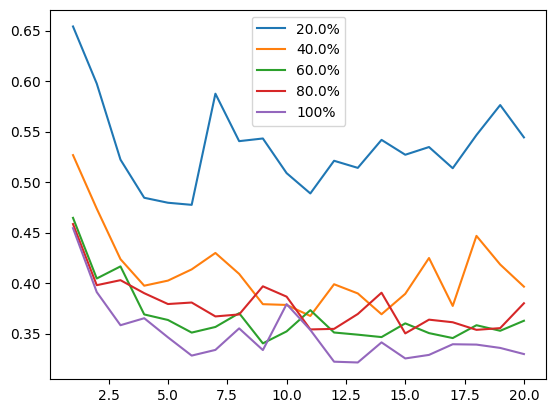

In [6]:
xs = list(range(1, EPOCHS + 1))
for i, p in enumerate(PERCENTEGES):
    ys = [x.loss for x in scores[i]]
    plt.plot(xs, ys)
labels = [f"{p * 100}%" for p in PERCENTEGES]
plt.legend(labels)

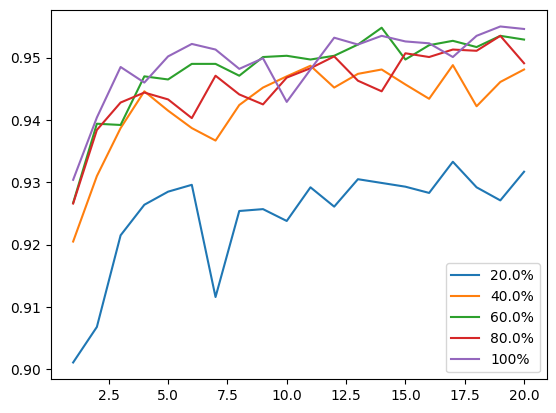

In [7]:
xs = list(range(1, EPOCHS + 1))
for i, p in enumerate(PERCENTEGES):
    ys = [x.accuracy for x in scores[i]]
    plt.plot(xs, ys)
labels = [f"{p * 100}%" for p in PERCENTEGES]
plt.legend(labels)

In [8]:
EPOCHS = 50
scores = []
for i in range(5):
    network = Network([784] + [30] * i + [10], optimizer=SGD(0.1), batch_size=10)
    score = network.train(train_data, EPOCHS, monitor_dataset=test_data)
    print(f"Hidden layers: {i}, {score[-1]}")
    scores.append(score)

Hidden layers: 0, accuracy: 91.60000000000001%, loss: 0.6595860840724187
Hidden layers: 1, accuracy: 96.26%, loss: 0.2753522014116142
Hidden layers: 2, accuracy: 95.54%, loss: 0.3133306204142874
Hidden layers: 3, accuracy: 95.88%, loss: 0.3062498967083937
Hidden layers: 4, accuracy: 95.16%, loss: 0.3483271646502696


# Слои, 1 - оптимально, >=2 не имеет смысла

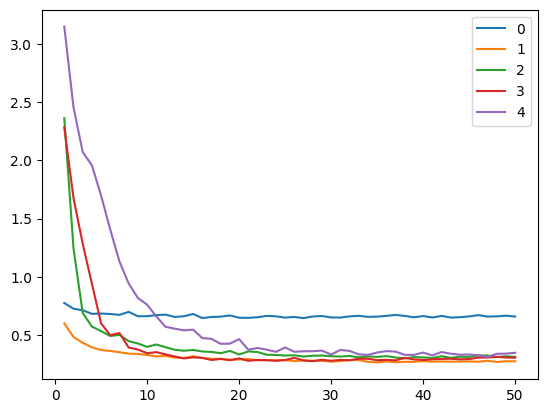

In [9]:
xs = list(range(1, EPOCHS + 1))
for i in range(5):
    ys = [x.loss for x in scores[i]]
    plt.plot(xs, ys)
labels = [str(i) for i in range(5)]
plt.legend(labels)

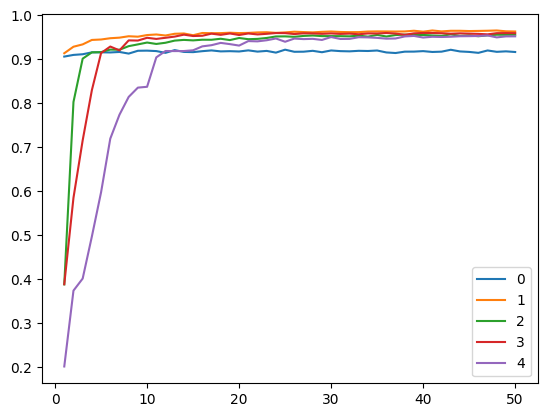

In [10]:
xs = list(range(1, EPOCHS + 1))
for i in range(5):
    ys = [x.accuracy for x in scores[i]]
    plt.plot(xs, ys)
labels = [str(i) for i in range(5)]
plt.legend(labels)

In [11]:
params = [
    (0, 0, 0),
    (0.001, 0, 0),
    (0, 0.001, 0),
    (0, 0, 0.5),
    (0.0005, 0.0005, 0),
]
labels = ["SGD", "L1", "L2", "Dropout", "L1+L2"]
scores = []
for i, p in enumerate(params):
    network = Network([784, 30, 10], SGD(0.1), 10, *p)
    score = network.train(train_data, 50, monitor_dataset=test_data)
    print(f"{labels[i]}: {score[-1]}")
    scores.append(score)

SGD: accuracy: 95.91%, loss: 0.3104181775608578
L1: accuracy: 96.57%, loss: 0.2457211677594207
L2: accuracy: 96.54%, loss: 0.25182591496958434
Dropout: accuracy: 94.67999999999999%, loss: 0.43362125441362176
L1+L2: accuracy: 96.25%, loss: 0.2622785145295476


# Регуляризация

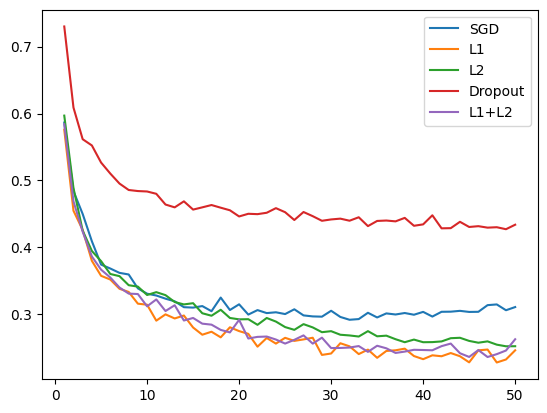

In [12]:
xs = list(range(1, 51))
for i in range(5):
    ys = [x.loss for x in scores[i]]
    plt.plot(xs, ys)
plt.legend(labels)

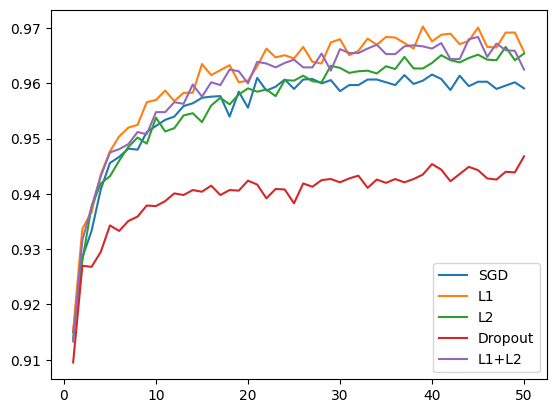

In [13]:
xs = list(range(1, 51))
for i in range(5):
    ys = [x.accuracy for x in scores[i]]
    plt.plot(xs, ys)
plt.legend(labels)